# VAD ET architecture evaluation

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import soundfile as sf
import pickle
from copy import copy
import torch
from vad_et import VadET

FILE = '2_flac/rev1-1624-168623-0028_5652-39938-0066_7800-283492-0002'
with np.load('../data/features/test/' + FILE + '.pvad.fea.npz') as f:
    x = f['x']
    embed = f['embed']
    y = f['y']
    x = np.hstack((x, np.full((x.shape[0], 256), embed)))

audio, sr = sf.read('../data/concat/' + FILE + '.flac')

model = VadET(input_dim=296, hidden_dim=64, num_layers=2, out_dim=3)
model.load_state_dict(torch.load('models/vad_et.pt'))

new_y = np.kron(y, np.ones(160))
new_x = np.kron(x[:,0] + x[:,1], np.ones(160))

In [13]:
# get the model to generate a label vector for us

conv_filter = np.array([1/8]*8)
conv_filter2 = np.cos([1, 0, -1, 0])

with torch.no_grad():
    x_torch = torch.nn.utils.rnn.pack_padded_sequence(torch.unsqueeze(torch.from_numpy(x).float(), 0),
                                                      torch.tensor([y.size]), batch_first=True)
    
   # y_frame = np.array([])
   # for frame in torch.from_numpy(x).float():
   #     frame_packed = torch.unsqueeze(torch.unsqueeze(frame, 0), 0)
   #     frame_packed = torch.nn.utils.rnn.pack_padded_sequence(frame_packed, torch.tensor([1]), batch_first=True)
   #     out_frame = torch.squeeze(model(frame_packed))
   #     y_frame = np.append(y, torch.argmax(out).numpy())
    
    softmax = torch.nn.Softmax(dim=1)
    output_raw = torch.squeeze(model(x_torch))
    output = torch.argmax(output_raw, dim=1)
    output_raw = softmax(output_raw).numpy()
    o0 = np.kron(output_raw[:, 0], np.ones(160))
    o1 = np.kron(output_raw[:, 1], np.ones(160))
    o2 = np.kron(output_raw[:, 2], np.ones(160))
    
    #output_hard = output_raw > 0.5
    ##output_conv = np.convolve(output_raw, conv_filter)
    #output_conv = np.convolve(np.convolve(output_raw, conv_filter), conv_filter2)
    #output_conv_hard = output_conv > 0.5
    o_raw = np.kron(output, np.ones(160))
    #o_hard = np.kron(output_hard, np.ones(160))
    #o_smooth = np.kron(replace_zero_sequences(output_hard, 8), np.ones(160))
    #o_conv = np.kron(output_conv, np.ones(160))

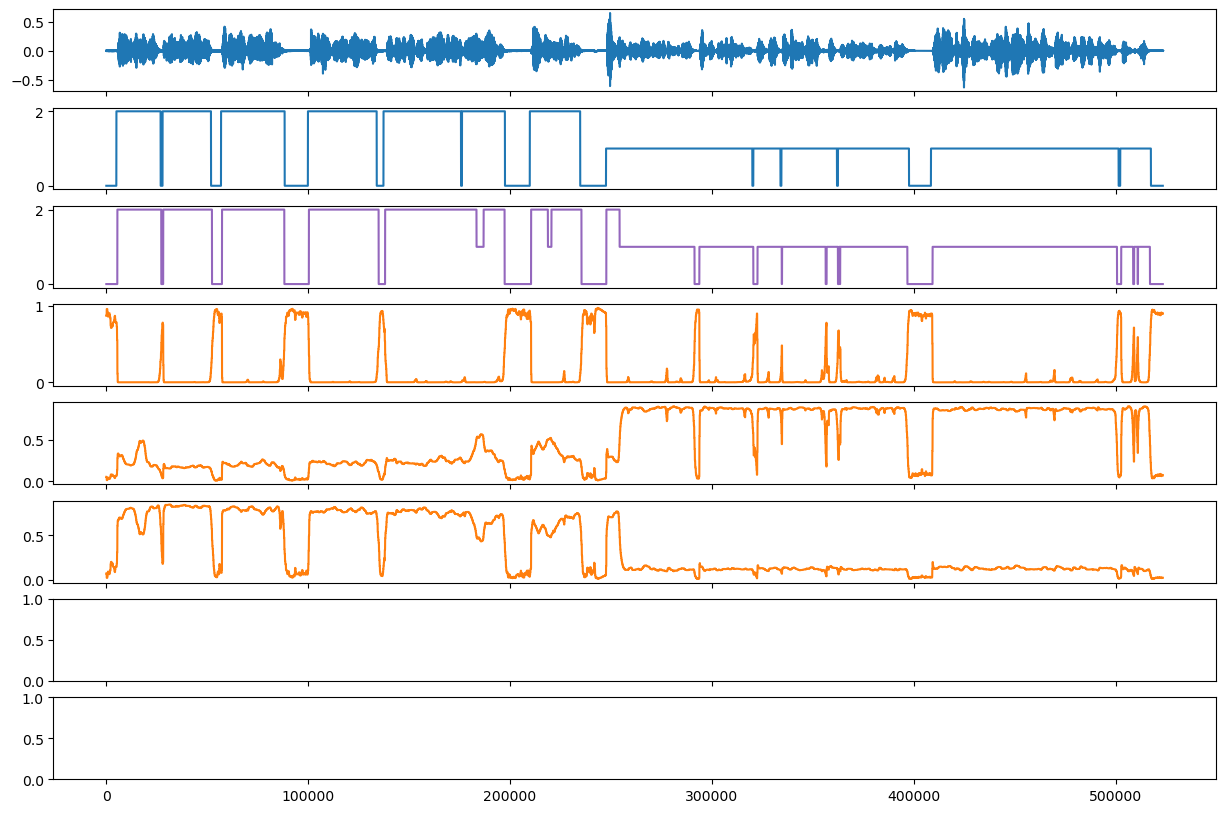

In [14]:
# Plot the original signal and labels plus the first two filterbank coefficients,
# the original shortest sequence and the edited label vector
mpl.style.use('default')
_, ax = plt.subplots(8, 1, figsize=(15,10), sharex=True)
ax[0].plot(audio)
ax[1].plot(new_y)
##ax[2].plot(new_x)
##ax[3].plot(seq)  # plot the position of the shortest sequence
##ax[2].plot(np.kron(replace_zero_sequences(y, 13), np.ones(160))) # deleted super short sequences
ax[2].plot(o_raw, 'C4') # plot the vad prediction
ax[3].plot(o0, 'C1') # plot the vad hard thresholded decision
ax[4].plot(o1, 'C1') # plot the vad hard thresholded decision with short sequences removed
ax[5].plot(o2, 'C1') # plot the vad filtered decision
#ax[6].plot(y_frame) # filtered, thresholded